# A Guide to Clustering

## Import

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans, OPTICS, SpectralClustering, AgglomerativeClustering
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.neighbors import NearestNeighbors

The task is to cluster a data set of customers into personality types.

In [111]:
Customers = pd.read_csv("marketing_campaign.csv", sep='\t')
Customers

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,13-06-2013,46,709,...,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,10-06-2014,56,406,...,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,25-01-2014,91,908,...,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,Master,Together,69245.0,0,1,24-01-2014,8,428,...,3,0,0,0,0,0,0,3,11,0


The 'Id' column is purely for labelling and should not be used for the cluster analysis. To have numeric values, we also convert the dates from 'Dt_Customer' to days since 01/01/1970.

In [112]:
print(Customers.columns)

y = Customers['ID']
X = Customers[Customers.columns.drop(['ID'])]  # id provides no relevant information

days = (pd.to_datetime(X['Dt_Customer'], format='%d-%m-%Y') - pd.Timestamp('1970-01-01')).dt.days  # array of days
date_col = pd.DataFrame({'Days_Customer': days})  # new data frame

# replace columns
X = X.drop(columns=['Dt_Customer'])
X = pd.concat([X, date_col], axis=1)
X

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')


,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Days_Customer
0,1957,Graduation,Single,58138.0,0,0,58,635,88,546,...,0,0,0,0,0,0,3,11,1,15587
1,1954,Graduation,Single,46344.0,1,1,38,11,1,6,...,0,0,0,0,0,0,3,11,0,16137
2,1965,Graduation,Together,71613.0,0,0,26,426,49,127,...,0,0,0,0,0,0,3,11,0,15938
3,1984,Graduation,Together,26646.0,1,0,26,11,4,20,...,0,0,0,0,0,0,3,11,0,16111
4,1981,PhD,Married,58293.0,1,0,94,173,43,118,...,0,0,0,0,0,0,3,11,0,16089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,1967,Graduation,Married,61223.0,0,1,46,709,43,182,...,0,0,0,0,0,0,3,11,0,15869
2236,1946,PhD,Together,64014.0,2,1,56,406,0,30,...,0,0,0,1,0,0,3,11,0,16231
2237,1981,Graduation,Divorced,56981.0,0,0,91,908,48,217,...,0,1,0,0,0,0,3,11,0,16095
2238,1956,Master,Together,69245.0,0,1,8,428,30,214,...,0,0,0,0,0,0,3,11,0,16094


## Preprocessing

Some columns contain categorical values, we need to preprocess them first:

In [113]:
for column in X.columns:
    if X[column].dtype == 'object' or X[column].dtype.name == 'category':
        print(f"C: {column} with values: {set(X[column])}")

C: Education with values: {'Master', '2n Cycle', 'PhD', 'Basic', 'Graduation'}
C: Marital_Status with values: {'Alone', 'YOLO', 'Together', 'Married', 'Single', 'Divorced', 'Widow', 'Absurd'}


The categories of education provide a natural ordering, which we will use. We will also group categories of Martial_Status together:

In [114]:
education_mapping = {'Basic': 0, '2nd Cycle': 1, 'Graduation': 2, 'Master': 3, 'PhD': 4}

education = X['Education'].map(education_mapping)
X = X.drop(columns=['Education'])
X = pd.concat([X, education], axis=1)

marital_mapping = {'Single': 'Single', 'Alone': 'Single', 'Divorced': 'Single', 'Widow': 'Single', 'Together': 'Together', 'Married': 'Together', 'YOLO': 'Miscellaneous', 'Absurd': 'Miscellaneous'}

marital = X['Marital_Status'].map(marital_mapping)
X = X.drop(columns=['Marital_Status'])
X = pd.concat([X, marital], axis=1)

X

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Days_Customer,Education,Marital_Status
0,1957,58138.0,0,0,58,635,88,546,172,88,...,0,0,0,0,3,11,1,15587,2.0,Single
1,1954,46344.0,1,1,38,11,1,6,2,1,...,0,0,0,0,3,11,0,16137,2.0,Single
2,1965,71613.0,0,0,26,426,49,127,111,21,...,0,0,0,0,3,11,0,15938,2.0,Together
3,1984,26646.0,1,0,26,11,4,20,10,3,...,0,0,0,0,3,11,0,16111,2.0,Together
4,1981,58293.0,1,0,94,173,43,118,46,27,...,0,0,0,0,3,11,0,16089,4.0,Together
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,1967,61223.0,0,1,46,709,43,182,42,118,...,0,0,0,0,3,11,0,15869,2.0,Together
2236,1946,64014.0,2,1,56,406,0,30,0,0,...,0,1,0,0,3,11,0,16231,4.0,Together
2237,1981,56981.0,0,0,91,908,48,217,32,12,...,0,0,0,0,3,11,0,16095,2.0,Single
2238,1956,69245.0,0,1,8,428,30,214,80,30,...,0,0,0,0,3,11,0,16094,3.0,Together


Still after grouping categories of 'Marital_Status' together, we still have no natural order. Thus, we will use One-Hot encoding. So a column with $n$ categorical values is transformed into $n$ columns with binary values.

In [115]:
encoder = OneHotEncoder(sparse_output=False)

# Loop through all columns in X
for column in X.columns:
    if X[column].dtype == 'object' or X[column].dtype.name == 'category':
        onehot = encoder.fit_transform(X[[column]])
        onehot_df = pd.DataFrame(onehot, columns=encoder.get_feature_names_out([column]))

        # Replace the original column with encoded columns
        X = X.drop(columns=[column])
        X = pd.concat([X, onehot_df], axis=1)

# remove nan values
X.dropna()
X = X.fillna(X.mean())

X

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Days_Customer,Education,Marital_Status_Miscellaneous,Marital_Status_Single,Marital_Status_Together
0,1957,58138.0,0,0,58,635,88,546,172,88,...,0,0,3,11,1,15587,2.0,0.0,1.0,0.0
1,1954,46344.0,1,1,38,11,1,6,2,1,...,0,0,3,11,0,16137,2.0,0.0,1.0,0.0
2,1965,71613.0,0,0,26,426,49,127,111,21,...,0,0,3,11,0,15938,2.0,0.0,0.0,1.0
3,1984,26646.0,1,0,26,11,4,20,10,3,...,0,0,3,11,0,16111,2.0,0.0,0.0,1.0
4,1981,58293.0,1,0,94,173,43,118,46,27,...,0,0,3,11,0,16089,4.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,1967,61223.0,0,1,46,709,43,182,42,118,...,0,0,3,11,0,15869,2.0,0.0,0.0,1.0
2236,1946,64014.0,2,1,56,406,0,30,0,0,...,0,0,3,11,0,16231,4.0,0.0,0.0,1.0
2237,1981,56981.0,0,0,91,908,48,217,32,12,...,0,0,3,11,0,16095,2.0,0.0,1.0,0.0
2238,1956,69245.0,0,1,8,428,30,214,80,30,...,0,0,3,11,0,16094,3.0,0.0,0.0,1.0


For some clustering algorithm a proper scaling of the data is necessary.

In [116]:
scaler = StandardScaler(with_std=True, with_mean=True)
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_scaled

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Days_Customer,Education,Marital_Status_Miscellaneous,Marital_Status_Single,Marital_Status_Together
0,-0.985345,0.235327,-0.825218,-0.929894,0.307039,0.983781,1.551577,1.679702,2.462147,1.476500,...,-0.11651,-0.097282,0.0,0.0,2.388846,-1.531185,-0.679109,-0.042295,1.352140,-1.346874
1,-1.235733,-0.235826,1.032559,0.906934,-0.383664,-0.870479,-0.636301,-0.713225,-0.650449,-0.631503,...,-0.11651,-0.097282,0.0,0.0,-0.418612,1.190545,-0.679109,-0.042295,1.352140,-1.346874
2,-0.317643,0.773633,-0.825218,-0.929894,-0.798086,0.362723,0.570804,-0.177032,1.345274,-0.146905,...,-0.11651,-0.097282,0.0,0.0,-0.418612,0.205773,-0.679109,-0.042295,-0.739568,0.742460
3,1.268149,-1.022732,1.032559,-0.929894,-0.798086,-0.870479,-0.560857,-0.651187,-0.503974,-0.583043,...,-0.11651,-0.097282,0.0,0.0,-0.418612,1.061881,-0.679109,-0.042295,-0.739568,0.742460
4,1.017761,0.241519,1.032559,-0.929894,1.550305,-0.389085,0.419916,-0.216914,0.155164,-0.001525,...,-0.11651,-0.097282,0.0,0.0,-0.418612,0.953012,1.562940,-0.042295,-0.739568,0.742460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,-0.150717,0.358568,-0.825218,0.906934,-0.107383,1.203678,0.419916,0.066692,0.081926,2.203398,...,-0.11651,-0.097282,0.0,0.0,-0.418612,-0.135680,-0.679109,-0.042295,-0.739568,0.742460
2236,-1.903435,0.470064,2.890335,0.906934,0.237969,0.303291,-0.661449,-0.606873,-0.687068,-0.655733,...,-0.11651,-0.097282,0.0,0.0,-0.418612,1.655713,1.562940,-0.042295,-0.739568,0.742460
2237,1.017761,0.189106,-0.825218,-0.929894,1.446700,1.795020,0.545656,0.221789,-0.101168,-0.364974,...,-0.11651,-0.097282,0.0,0.0,-0.418612,0.982703,-0.679109,-0.042295,1.352140,-1.346874
2238,-1.068807,0.679035,-0.825218,0.906934,-1.419719,0.368666,0.092992,0.208495,0.777683,0.071165,...,-0.11651,-0.097282,0.0,0.0,-0.418612,0.977755,0.441916,-0.042295,-0.739568,0.742460


## Analysis

The Hopkins Statistics $H$ describes the general data distribution, for $H \approx 0$ we have regular data like grids, for $H \approx 0.5$ we have uniform data and for $H \approx 1$ we have highly clustered data.

In [117]:
def hopkins(X):
    d = X.shape[1]
    n = len(X)
    m = int(0.1 * n)  # heuristic to choose 10% of the dataset points

    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
    rand_X = np.random.rand(m, d)
    
    ujd = []
    wjd = []
    
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors([rand_X[j]], 2, return_distance=True)
        ujd.append(u_dist[0][1])
        
        w_dist, _ = nbrs.kneighbors([X.sample(1).values[0]], 2, return_distance=True)
        wjd.append(w_dist[0][1])
        
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    return H

hopkins_stat = hopkins(X)
print(f"Hopkins Statistic: {hopkins_stat}")

hopkins_stat = hopkins(X_scaled)
print(f"Hopkins Statistic Scaled: {hopkins_stat}")

Hopkins Statistic: 0.9893752086243323
Hopkins Statistic Scaled: 0.6683555599091467


The dataset seems to be highly clustered, but interestingly the scaled data set has a far lower Hopkins Statistic. 

## Different Clustering Methods

### k-Means

To use k-Means, the number of clusters must be specified in advance. Since the algorithm is quite sensitive to this parameter, we compare the [Silhouette Coefficient](https://en.wikipedia.org/wiki/Silhouette_(clustering)) (higher is better) and the [Davies–Bouldin index](https://en.wikipedia.org/wiki/Davies%E2%80%93Bouldin_index) (lower is better) of different $k$.

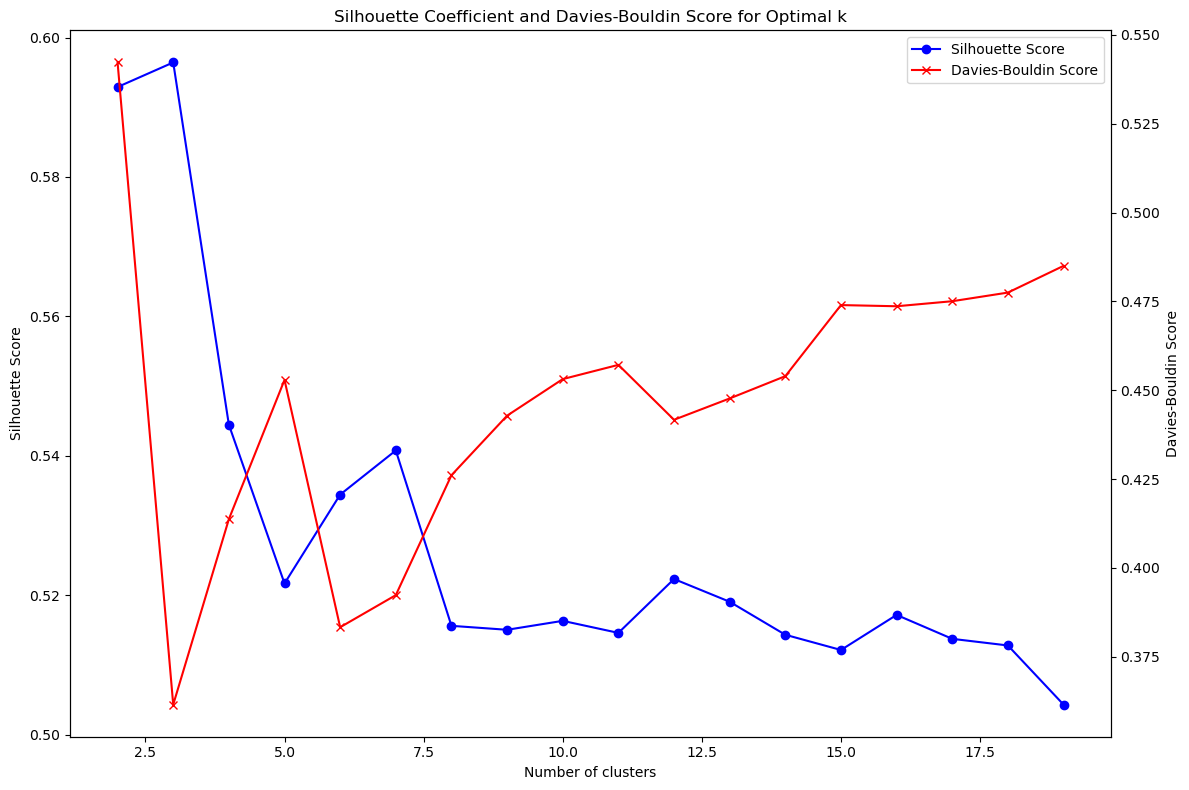

In [118]:
cluster_scores = []
silhouette_scores = []
limK = 20

for k in range(2, limK):
    kmeans = KMeans(n_clusters=k, random_state=0,)
    kmeans.fit(X)
    cluster_scores.append(davies_bouldin_score(X, kmeans.labels_))
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

fig, ax1 = plt.subplots(figsize=(12, 8))
ax1.plot(range(2, limK), silhouette_scores, marker='o', color='b', label='Silhouette Score')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Silhouette Score')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
ax2.plot(range(2, limK), cluster_scores, marker='x', color='r', label='Davies-Bouldin Score')
ax2.set_ylabel('Davies-Bouldin Score')
ax2.tick_params(axis='y')
plt.title('Silhouette Coefficient and Davies-Bouldin Score for Optimal k')
fig.tight_layout()  # Adjust layout to make room for the two y-axes
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.show()

The optimal number of clusters seem to be $3$, which is too low for our application. Thus, we will choose the next local minimum, $k = 6$.

### Expectation Maximization

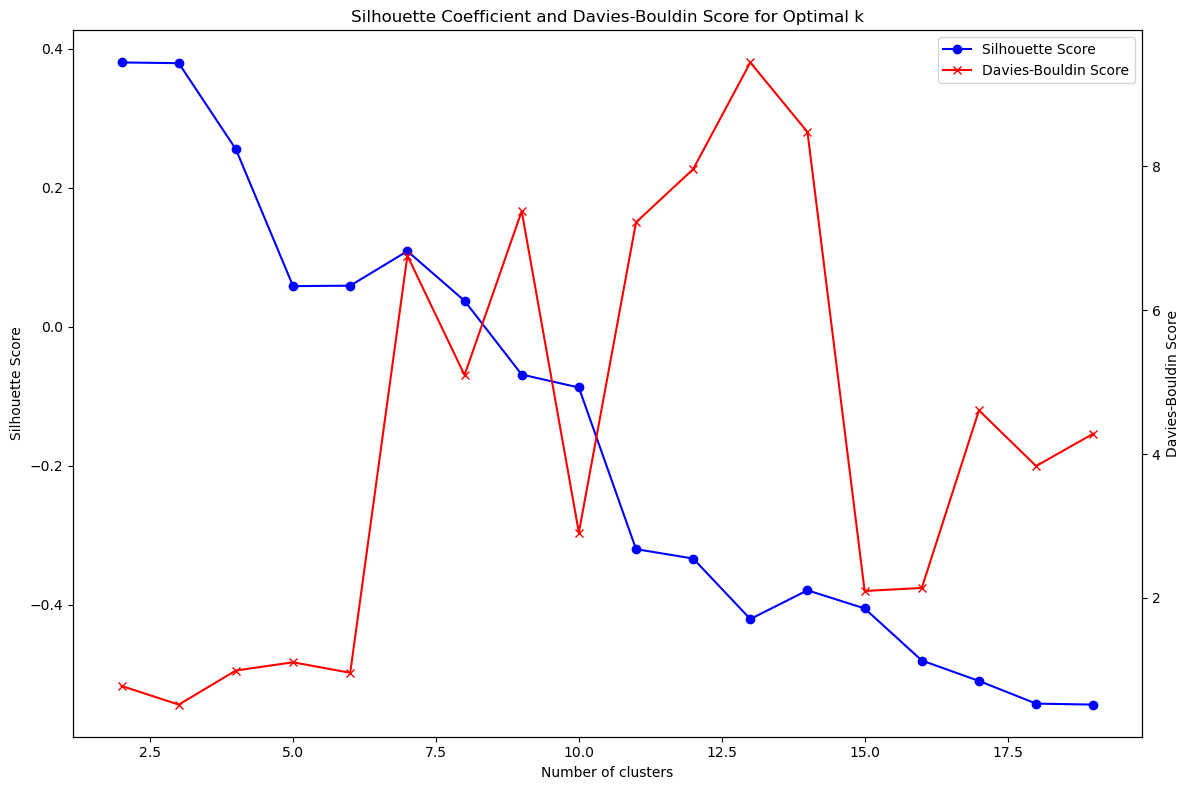

In [119]:
cluster_scores = []
silhouette_scores = []
limK = 20

for k in range(2, limK):
    gmm = GaussianMixture(n_components=k, random_state=0)
    gmm.fit(X)
    labels = gmm.predict(X)
    cluster_scores.append(davies_bouldin_score(X, labels))
    silhouette_scores.append(silhouette_score(X, labels))

fig, ax1 = plt.subplots(figsize=(12, 8))
ax1.plot(range(2, limK), silhouette_scores, marker='o', color='b', label='Silhouette Score')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Silhouette Score')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
ax2.plot(range(2, limK), cluster_scores, marker='x', color='r', label='Davies-Bouldin Score')
ax2.set_ylabel('Davies-Bouldin Score')
ax2.tick_params(axis='y')
plt.title('Silhouette Coefficient and Davies-Bouldin Score for Optimal k')
fig.tight_layout()  # Adjust layout to make room for the two y-axes
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.show()

Again we observe poor performance for $\geq 7$ clusters. And in general the clusters found by Expectation Maximization seem to be of worse quality than those of k-Means.

### OPTICS

Now we don't specify the number of clusters anymore, instead we need to specify how many $\varepsilon$-neighbours one point needs to have to become a core point.

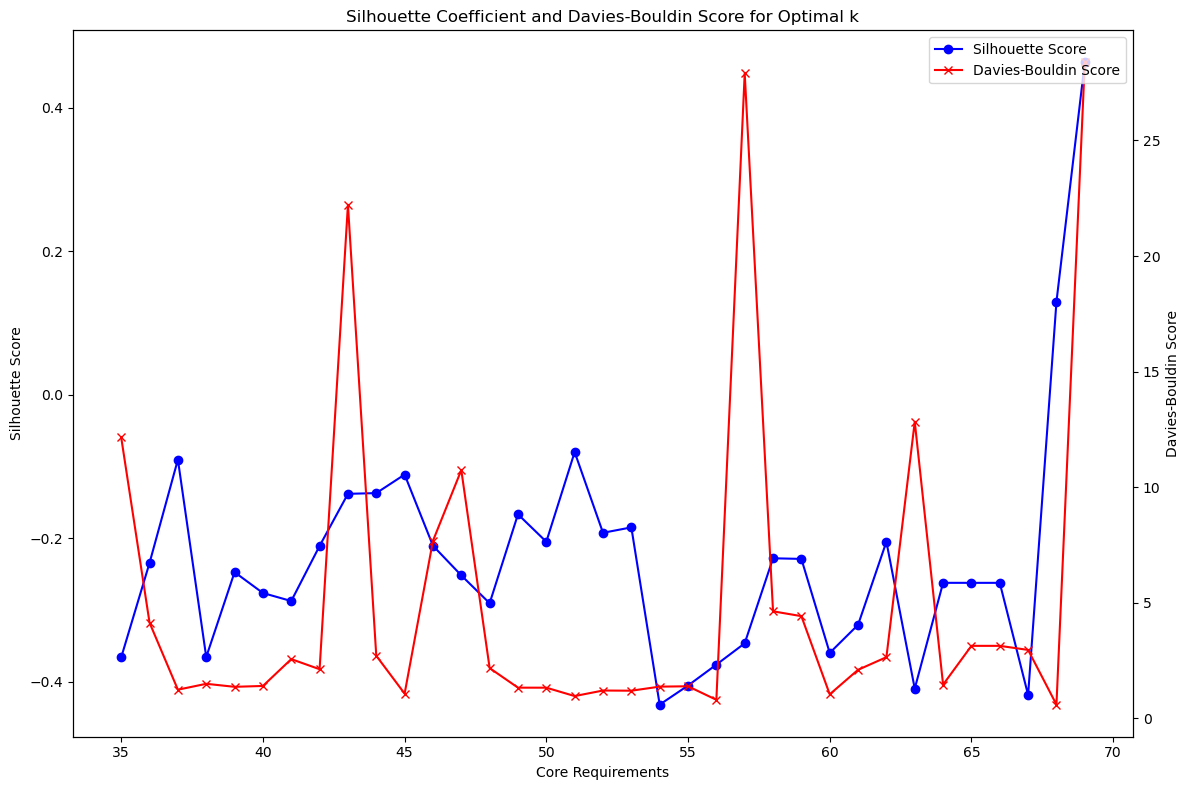

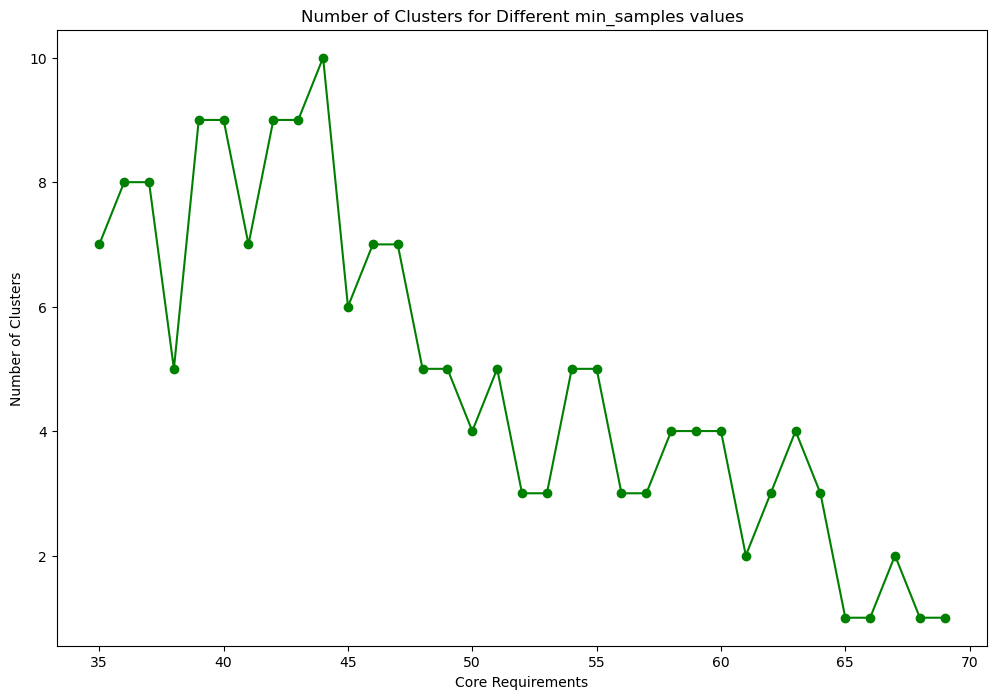

In [120]:
cluster_scores = []
silhouette_scores = []
cluster_count = []
sample_range = range(35, 70)

for k in sample_range:
    optics = OPTICS(min_samples=k)
    optics.fit(X)
    cluster_scores.append(davies_bouldin_score(X, optics.labels_))
    silhouette_scores.append(silhouette_score(X, optics.labels_))
    cluster_count.append(len(set(optics.labels_)) - (1 if -1 in optics.labels_ else 0))

fig, ax1 = plt.subplots(figsize=(12, 8))
ax1.plot(sample_range, silhouette_scores, marker='o', color='b', label='Silhouette Score')
ax1.set_xlabel('Core Requirements')
ax1.set_ylabel('Silhouette Score')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
ax2.plot(sample_range, cluster_scores, marker='x', color='r', label='Davies-Bouldin Score')
ax2.set_ylabel('Davies-Bouldin Score')
ax2.tick_params(axis='y')
plt.title('Silhouette Coefficient and Davies-Bouldin Score for Optimal k')
fig.tight_layout()  # Adjust layout to make room for the two y-axes
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(sample_range, cluster_count, marker='o', color='g')
plt.xlabel('Core Requirements')
plt.ylabel('Number of Clusters')
plt.title('Number of Clusters for Different min_samples values')
plt.show()

We quickly observe that `min_samples` needs to chosen quite high, to avoid an astronomical number of clusters. The best value seems to be $54$, but even this value has a very poor Silhouette Coefficient.

### Spectral Clustering

/home/mia/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/mia/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/mia/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/mia/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/mia/.local/lib/python3.10/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/home/mia/.local/lib

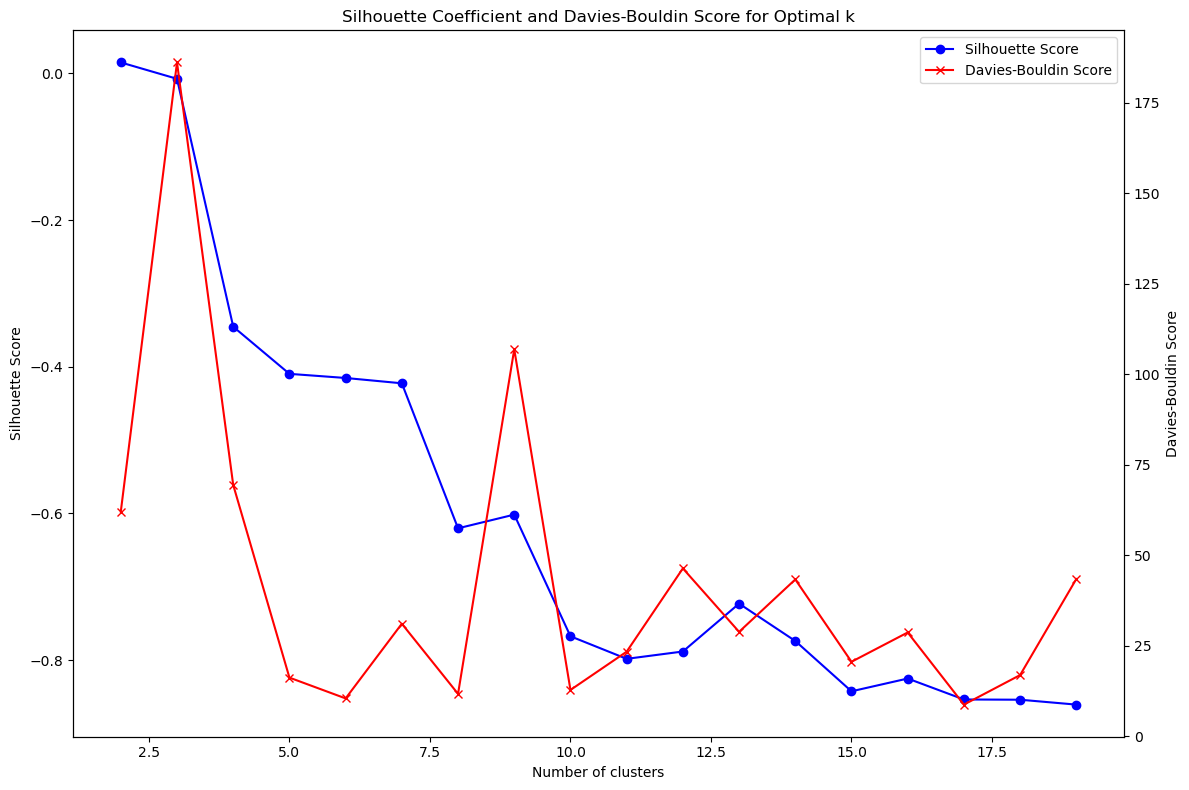

In [121]:
cluster_scores = []
silhouette_scores = []
limK = 20

for k in range(2, limK):
    sc = SpectralClustering(n_clusters=k, random_state=0,)
    sc.fit(X)
    cluster_scores.append(davies_bouldin_score(X, sc.labels_))
    silhouette_scores.append(silhouette_score(X, sc.labels_))

fig, ax1 = plt.subplots(figsize=(12, 8))
ax1.plot(range(2, limK), silhouette_scores, marker='o', color='b', label='Silhouette Score')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Silhouette Score')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
ax2.plot(range(2, limK), cluster_scores, marker='x', color='r', label='Davies-Bouldin Score')
ax2.set_ylabel('Davies-Bouldin Score')
ax2.tick_params(axis='y')
plt.title('Silhouette Coefficient and Davies-Bouldin Score for Optimal k')
fig.tight_layout()  # Adjust layout to make room for the two y-axes
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.show()

Again the Silhouette Coefficient is very poor.

### Hierarchical Clustering

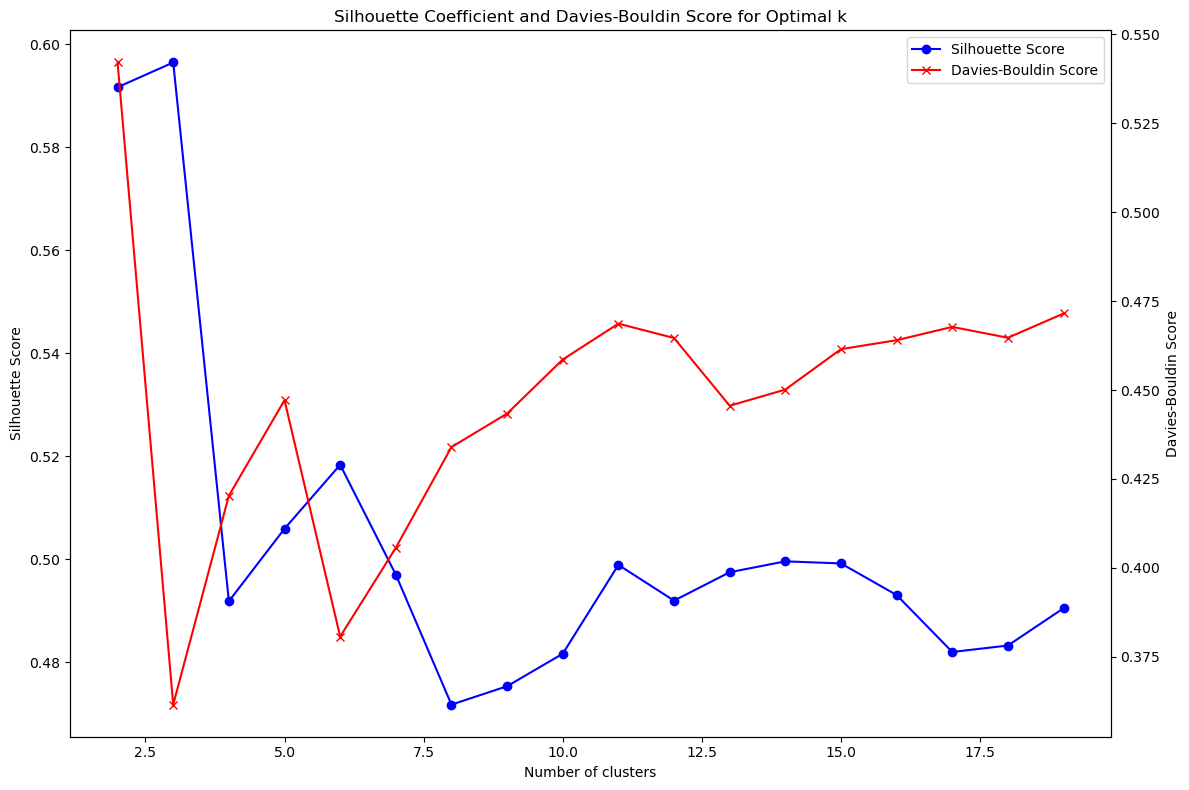

In [122]:
cluster_scores = []
silhouette_scores = []
limK = 20

for k in range(2, limK):
    ag = AgglomerativeClustering(n_clusters=k)
    ag.fit(X)
    cluster_scores.append(davies_bouldin_score(X, ag.labels_))
    silhouette_scores.append(silhouette_score(X, ag.labels_))

fig, ax1 = plt.subplots(figsize=(12, 8))
ax1.plot(range(2, limK), silhouette_scores, marker='o', color='b', label='Silhouette Score')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Silhouette Score')
ax1.tick_params(axis='y')
ax2 = ax1.twinx()
ax2.plot(range(2, limK), cluster_scores, marker='x', color='r', label='Davies-Bouldin Score')
ax2.set_ylabel('Davies-Bouldin Score')
ax2.tick_params(axis='y')
plt.title('Silhouette Coefficient and Davies-Bouldin Score for Optimal k')
fig.tight_layout()  # Adjust layout to make room for the two y-axes
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
plt.show()

Hierarchical clustering seems to work very nicely with our data set, together with k-Means we achieve the best scores. Again, $k = 6$ seems to be a sweetspot. We can also compare different linkage methods:

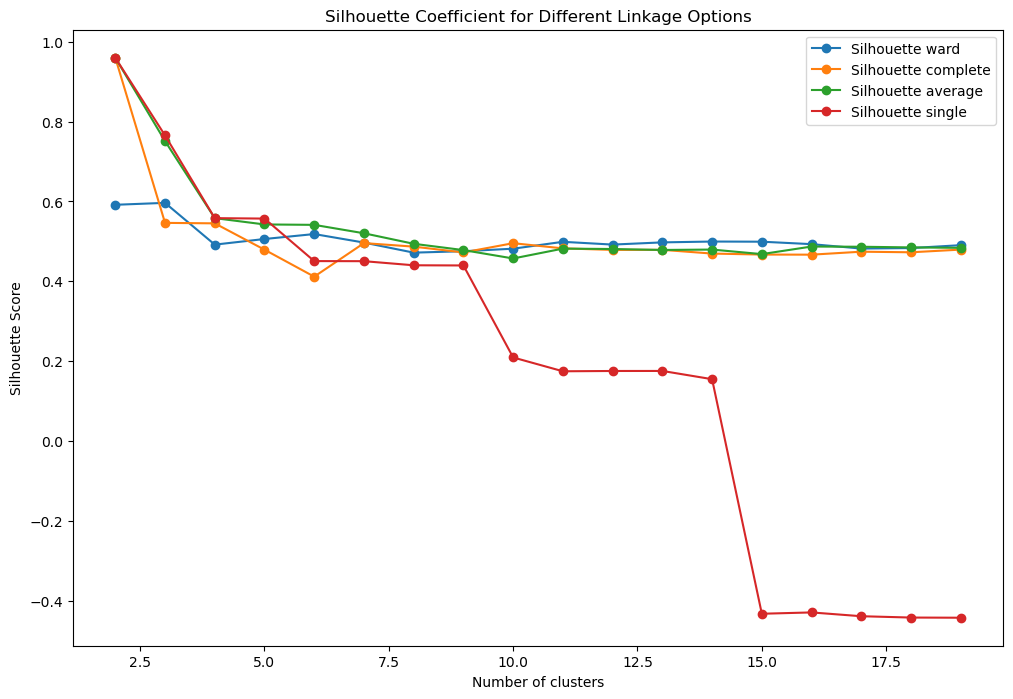

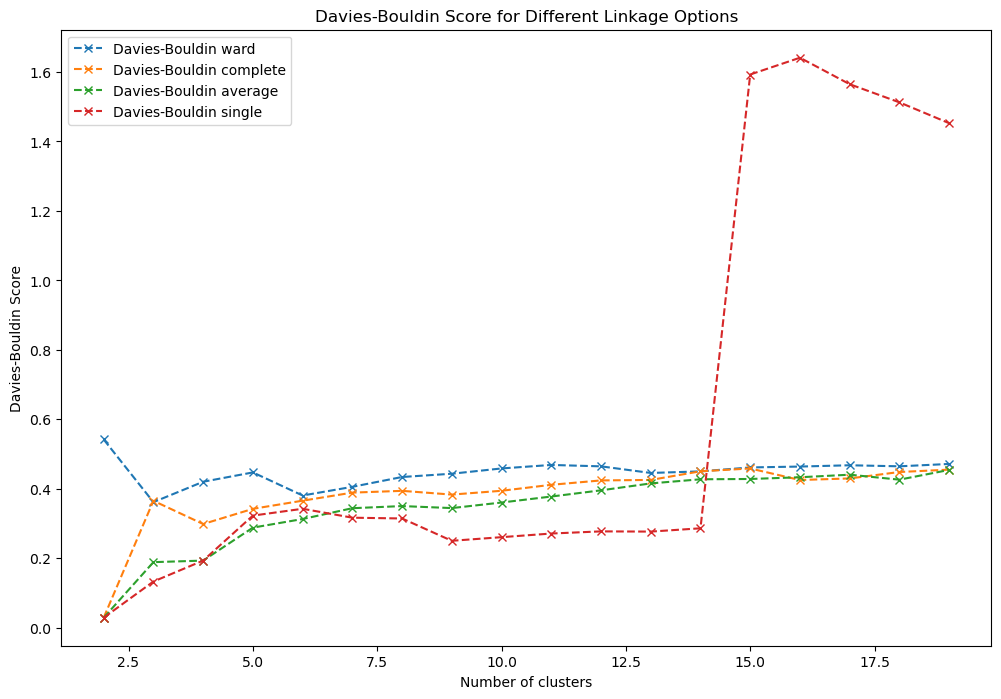

In [123]:
limK = 20
linkage_options = ['ward', 'complete', 'average', 'single']
results = {linkage: {'silhouette': [], 'davies_bouldin': []} for linkage in linkage_options}

# Loop over different linkage options and number of clusters
for linkage in linkage_options:
    for k in range(2, limK):
        ag = AgglomerativeClustering(n_clusters=k, linkage=linkage)
        ag.fit(X)
        labels = ag.labels_
        results[linkage]['silhouette'].append(silhouette_score(X, labels))
        results[linkage]['davies_bouldin'].append(davies_bouldin_score(X, labels))

# Plot Silhouette Scores
plt.figure(figsize=(12, 8))
for linkage in linkage_options:
    plt.plot(range(2, limK), results[linkage]['silhouette'], marker='o', label=f'Silhouette {linkage}')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Coefficient for Different Linkage Options')
plt.legend()
plt.show()

# Plot Davies-Bouldin Scores
plt.figure(figsize=(12, 8))
for linkage in linkage_options:
    plt.plot(range(2, limK), results[linkage]['davies_bouldin'], marker='x', linestyle='dashed', label=f'Davies-Bouldin {linkage}')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin Score')
plt.title('Davies-Bouldin Score for Different Linkage Options')
plt.legend()
plt.show()


We observe the default option 'ward' works about as well as 'average' and 'complete', only 'single' does significantly worse when the number of clusters increases.

(c) Mia Müßig